In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys
import sklearn
from sklearn import metrics
import os
import pandas as pd
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import logging
logging.disable(30)
from collections import  Counter
import math
import random
from fitter import Fitter
random_seed =3407
tf.random.set_seed(random_seed )
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [2]:
source_data=np.load(r"48kcwru_data.npy")
source_label=np.load(r"48kcwru_label.npy")

target_data=np.load(r"seu2_data.npy")
target_label=np.load(r"seu2_label.npy")

source_data.shape,source_label.shape,target_data.shape,target_label.shape

((4000, 3072), (4000, 4), (4000, 3072), (4000, 4))

In [3]:
source_data=(source_data-source_data.min(axis=1).reshape((len(source_data),1)))/(source_data.max(axis=1).reshape((len(source_data),1))-source_data.min(axis=1).reshape((len(source_data),1)))
target_data=(target_data-target_data.min(axis=1).reshape((len(target_data),1)))/(target_data.max(axis=1).reshape((len(target_data),1))-target_data.min(axis=1).reshape((len(target_data),1)))

In [4]:
source_data=tf.expand_dims(source_data,axis=-1)
target_data=tf.expand_dims(target_data,axis=-1)

In [5]:
train_dataset=tf.data.Dataset.from_tensor_slices((source_data,target_data,source_label,target_label))
train_dataset=train_dataset.shuffle(4000).batch(128,drop_remainder=True)

test_dataset=tf.data.Dataset.from_tensor_slices((source_data,target_data,source_label,target_label))
test_dataset=test_dataset.batch(4000,drop_remainder=True)

In [6]:
def Model():
    input_1=tf.keras.Input(shape=(3072,1))

    x=tf.keras.layers.Conv1D(filters=16,kernel_size=64,strides=16,activation='relu',padding='same')(input_1)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding='same')(x)

    x=tf.keras.layers.Conv1D(filters=32,kernel_size=3,strides=1,activation='relu',padding='same')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding='same')(x)

    x=tf.keras.layers.Conv1D(filters=64,kernel_size=3,strides=1,activation='relu',padding='same')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding='same')(x)

    x=tf.keras.layers.Conv1D(filters=128,kernel_size=3,strides=1,activation='relu',padding='same')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding='same')(x)

    x=tf.keras.layers.Conv1D(filters=256,kernel_size=3,strides=1,activation='relu',padding='same')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding='same')(x)

    x=tf.keras.layers.GlobalAveragePooling1D()(x)

    y1=tf.keras.layers.Dense(128,activation='relu')(x)
    y2=tf.keras.layers.Dense(4)(y1)

    model=tf.keras.Model(inputs=input_1,outputs=[y1,y2])
    
    return model

model=Model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 192, 16)           1040      
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 16)           64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 96, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 32)            1568      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 32)            128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 32)            0     

In [7]:
pre_optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)             
loss_func=tf.keras.losses.CategoricalCrossentropy(from_logits=True) 

In [8]:
def mix_rbf_mmsd(X, Y, sigmas=(1,), wts=None, biased=True):
    K_XX, K_XY, K_YY, d = _mix_rbf_kernel(X, Y, sigmas, wts)
    return _mmsd(K_XX, K_XY, K_YY, const_diagonal=d, biased=biased)


def _mix_rbf_kernel(X, Y, sigmas, wts=None):
    if wts is None:
        wts = [1] * len(sigmas)

    XX = tf.matmul(X, X, transpose_b=True)
    XY = tf.matmul(X, Y, transpose_b=True)
    YY = tf.matmul(Y, Y, transpose_b=True)

    X_sqnorms = tf.linalg.diag_part(XX)
    Y_sqnorms = tf.linalg.diag_part(YY)

    r = lambda x: tf.expand_dims(x, 0)
    c = lambda x: tf.expand_dims(x, 1)

    K_XX, K_XY, K_YY = 0, 0, 0
    for sigma, wt in zip(sigmas, wts):
        gamma = 1 / (2 * sigma**2)
        K_XX += wt * tf.exp(-gamma * (-2 * XX + c(X_sqnorms) + r(X_sqnorms)))
        K_XY += wt * tf.exp(-gamma * (-2 * XY + c(X_sqnorms) + r(Y_sqnorms)))
        K_YY += wt * tf.exp(-gamma * (-2 * YY + c(Y_sqnorms) + r(Y_sqnorms)))
    return K_XX, K_XY, K_YY, tf.reduce_sum(wts)
    

def _mmsd(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    m = tf.cast(K_XX.get_shape()[0], tf.float32)
    n = tf.cast(K_YY.get_shape()[0], tf.float32)
    
    C_K_XX=tf.pow(K_XX,2)
    C_K_YY=tf.pow(K_YY,2)
    C_K_XY=tf.pow(K_XY,2)


    if biased:
        mmsd = (tf.reduce_sum(C_K_XX) / (m * m)
              + tf.reduce_sum(C_K_YY) / (n * n)
              - 2 * tf.reduce_sum(C_K_XY) / (m * n))
    else:
        if const_diagonal is not False:
            trace_X = m * const_diagonal
            trace_Y = n * const_diagonal
        else:
            trace_X = tf.linalg.trace(C_K_XX)
            trace_Y = tf.linalg.trace(C_K_YY)

        mmsd = ((tf.reduce_sum(C_K_XX) - trace_X) / ((m-1) * m)
              + (tf.reduce_sum(C_K_YY) - trace_Y) / ((n-1) * n)
              - 2 * tf.reduce_sum(C_K_XY) / (m* n))
    return mmsd

In [9]:
def mmsd_rbf_loss(X1,X2, bandwidths=[3]):
    kernel_loss = mix_rbf_mmsd(X1,X2, sigmas=bandwidths)
    return kernel_loss

In [10]:
clc_loss=tf.keras.metrics.Mean('clc_loss')                       
mmsd_loss=tf.keras.metrics.Mean('mvd_loss')

train_accuracy=tf.keras.metrics.CategoricalAccuracy('train_accuracy')
test_accuracy=tf.keras.metrics.CategoricalAccuracy('test_accuracy')

train_acc=[]
test_acc=[]
clc_loss_=[]
mmsd_loss_=[]

In [11]:
def train_step(model, source_data,target_data,source_label,target_label):
    u=1
    with tf.GradientTape() as t:
        out1,output1 = model(source_data,training = True)                              
        out2,output2 = model(target_data,training = True)                               
        loss_step =loss_func(source_label,output1) + u*mmsd_rbf_loss(output1,output2)      
    grads = t.gradient(loss_step, model.trainable_variables)
    
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    mmsd_loss(u*mmsd_rbf_loss(output1,output2))
    clc_loss(loss_func(source_label,output1))
    train_accuracy(source_label,output1)
    test_accuracy(target_label,output2)

    
def train(epochs):
    for epoch in range(epochs):
        for (batch, (source_data,target_data,source_label,target_label)) in enumerate(train_dataset):
            train_step(model,source_data,target_data,source_label,target_label)
        train_acc.append(train_accuracy.result())
        mmsd_loss_.append(mmsd_loss.result())
        clc_loss_.append(clc_loss.result())
        test_acc.append(test_accuracy.result())
        
        print('Epoch{}, mmsd_loss is {:.5f}, clc_loss is {:.5f}, train_accuracy is {:.5f},test_accuracy is {:.5f}'.format(epoch+1,
                                                                                          mmsd_loss.result(),
                                                                                          clc_loss.result(),           
                                                                                          train_accuracy.result(),
                                                                                          test_accuracy.result()))
        
        mmsd_loss.reset_states()
        clc_loss.reset_states()
        train_accuracy.reset_states()
        test_accuracy.reset_states()

In [12]:
epochs=100
train(epochs)

Epoch1, mmsd_loss is 0.08100, clc_loss is 0.12461, train_accuracy is 0.96043,test_accuracy is 0.62324
Epoch2, mmsd_loss is 0.02677, clc_loss is 0.00378, train_accuracy is 0.99950,test_accuracy is 0.79839
Epoch3, mmsd_loss is 0.02105, clc_loss is 0.00151, train_accuracy is 1.00000,test_accuracy is 0.85005
Epoch4, mmsd_loss is 0.01808, clc_loss is 0.00089, train_accuracy is 1.00000,test_accuracy is 0.86316
Epoch5, mmsd_loss is 0.01743, clc_loss is 0.00130, train_accuracy is 1.00000,test_accuracy is 0.86290
Epoch6, mmsd_loss is 0.01673, clc_loss is 0.00102, train_accuracy is 0.99975,test_accuracy is 0.88281
Epoch7, mmsd_loss is 0.01601, clc_loss is 0.00046, train_accuracy is 1.00000,test_accuracy is 0.89743
Epoch8, mmsd_loss is 0.01609, clc_loss is 0.00094, train_accuracy is 0.99950,test_accuracy is 0.90827
Epoch9, mmsd_loss is 0.01517, clc_loss is 0.00056, train_accuracy is 1.00000,test_accuracy is 0.92087
Epoch10, mmsd_loss is 0.01405, clc_loss is 0.00045, train_accuracy is 1.00000,test

Epoch81, mmsd_loss is 0.00011, clc_loss is 0.00002, train_accuracy is 1.00000,test_accuracy is 1.00000
Epoch82, mmsd_loss is 0.00012, clc_loss is 0.00002, train_accuracy is 1.00000,test_accuracy is 1.00000
Epoch83, mmsd_loss is 0.00010, clc_loss is 0.00002, train_accuracy is 1.00000,test_accuracy is 1.00000
Epoch84, mmsd_loss is 0.00012, clc_loss is 0.00002, train_accuracy is 1.00000,test_accuracy is 1.00000
Epoch85, mmsd_loss is 0.00012, clc_loss is 0.00002, train_accuracy is 1.00000,test_accuracy is 1.00000
Epoch86, mmsd_loss is 0.00011, clc_loss is 0.00002, train_accuracy is 1.00000,test_accuracy is 1.00000
Epoch87, mmsd_loss is 0.00010, clc_loss is 0.00002, train_accuracy is 1.00000,test_accuracy is 1.00000
Epoch88, mmsd_loss is 0.00011, clc_loss is 0.00002, train_accuracy is 1.00000,test_accuracy is 1.00000
Epoch89, mmsd_loss is 0.00009, clc_loss is 0.00002, train_accuracy is 1.00000,test_accuracy is 1.00000
Epoch90, mmsd_loss is 0.00010, clc_loss is 0.00002, train_accuracy is 1.0

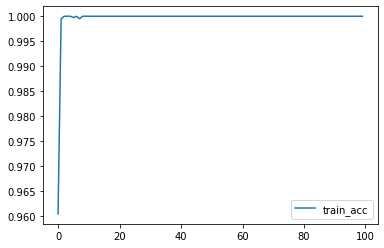

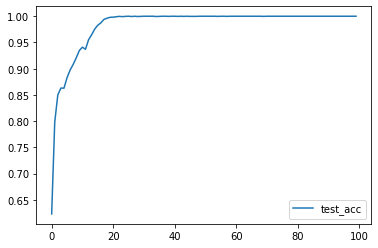

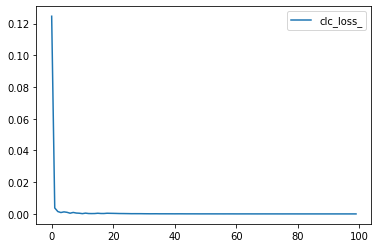

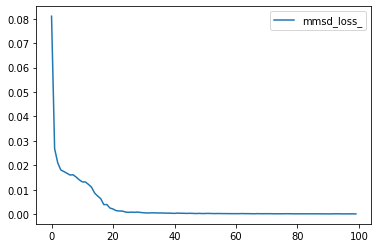

In [13]:
string=['train_acc','test_acc','clc_loss_','mmsd_loss_']
for i in string:
    plt.plot(eval(i),label=i)
    plt.legend()
    plt.show()